In [174]:
using Plots
using LaTeXStrings, ColorSchemes
using CSV, DataFrames
Plots.PyPlotBackend()

plot_font = "Computer Modern"
default(fontfamily=plot_font, grid=false, color=ColorSchemes.berlin[1])

function fluid_plot(sol, time_skip, save_every, x, s, tmax)
    dt = floor(Int64, time_skip / save_every)
    plt = plot(x, s, dpi=200, xlabel=L"Dimensionless length $x$", ylabel=L"Dimensionless free surface height $\phi$", legend=false, color="black",
        title=L"Fluid profile at $\delta t = %$time_skip$ intervals", ylims=(0, Inf), xlims=(0, Lx))
    for i = 1:floor(Int64, tmax / time_skip)+1
        plot!(plt, x, sol.u[1+dt*(i-1)][2:end-1] + s)
    end
    plot!(plt, x, s, color="black")
    return plt
end

function fluid_anim(sol, ymax, xmax, x, s)
    anim = @animate for i = 1:size(sol.u)[1]
        timestep = sol.t[i]
        plot(x, sol.u[i][2:end-1] + s, legend=false, ylims=(0, ymax), xlims=(0, Lx), title=L"Fluid Profile $(t=%$timestep)$",
            xlabel=L"Dimensionless length $x$", ylabel=L"Dimensionless free surface height $\phi$")
        plot!(x, s, color="black")
    end
    return anim
end

"""
Function to save fluid profile data to a CSV. CSV saved in the format of:
Timestamp | Ghost 1 | 0 | ... | Lx | Ghost 2
# Arguments
- `sol`: solution object of DiffEq solver
"""
function fluid_data(sol, path)
    CSV.write(path * "/data.csv", DataFrame(sol))
end

function save_params(path, filename="params")
    open(path * "/" * filename * ".txt", "w") do f
        domain_info = "# Domain Parameters\nnx: $nx\nLx: $Lx\ndx: $dx\n"
        topo_info = "\n# Topography Parameters\n$topo\n"
        init_cond_info = "\n# Initial Condition Parameters\n$ic_obj\n"
        ode_sys_info = "\n# ODE System Parameters\nD: $D\nWe_ac: $We_ac\nalpha: $α\nepsilon: $ϵ\nalpha_1: $α_1\nlambda: $λ\n"
        time_info = "\n# Time Parameters\ntime_span: $tspan\ntimestep_save: $save_every"
        write(f, domain_info * topo_info * init_cond_info * ode_sys_info * time_info)
    end
end

save_params (generic function with 2 methods)

In [2]:
"""
Custom struct for topogrpahy functions
"""
struct Topography
    f::Function
    params::Tuple
end

"""
Function describing a flat plane
"""
function flat(x)
    0
end

"""
Function describing a bump
# Arguments
- `x`: x coordinate
- `w`: width scaling
- `c`: x coordinate for the center of the bump
- `h`: optional arg for height scaling
"""
function bump(x, w, c, h=1)
    if x <= c - w || x >= c + w
        return 0
    else
        return h * exp(-(w^2 / (w^2 - (x - c)^2)))
    end
end

"""
Function describing a rectangular mound
# Arguments
- `x`: x coordinate
- `c`: x coordinate for left hand corner of mound
- `h`: height of mound
- `delta`: steepness of mound
- `w`: width of mound
"""
function mound(x, c, h, delta, w)
    h * (1 / pi * (atan((x - c) / delta) - atan((x - c - w) / delta)))
end

"""
Custom struct for initial condition functions
"""
struct InitialCondition
    f::Function
    params::Tuple
end

"""
Function describing a reflected sigmoid
# Arguments
- `x`: x coordinate
- `b`: precursor film height
- `xf`: center point of transition
- `c`: steepness of transition
- `h`: optional argument control initial height
"""
function reflected_sigmoid(x, b, xf, c, h=1)
    b + (h - b) / (1 + exp(1 / c * (x - xf)))
end

"""
Function describing a flat plane with respect to phi = 0
# Arguments
- `h`: film height relative to phi = 0
- `s`: topography
"""
function flat_profile(x, h, s, b=0.0)
    h - s + b
end

function front_tanh(x)
    0.45 * tanh(-5 * (x - 5)) + 0.55
end

"""
Function describing a bump
# Arguments
- `x`: x coordinate
- `w`: width scaling
- `c`: x coordinate for the center of the bump
- `b`: precursor film height
- `h`: optional arg for height scaling
"""
function ic_bump(x, w, c, b, h=1)
    if x <= c - w || x >= c + w
        return b
    else
        return h * exp(-(w^2 / (w^2 - (x - c)^2))) + b
    end
end

ic_bump

In [255]:
plot_font = "Computer Modern"
default(fontfamily=plot_font, grid=false)
# ================================
# Discretization of x-domain
# ================================
Lx = 100
dx = 0.05
nx = Lx / dx
x = 0.0:dx:Lx

# ================================
# Topography definition
# ================================
topo = Topography(flat, ())
#topo = Topography(bump, (5.0,  40.0))
s = topo.f.(x, topo.params...)

# ================================
# Initial Condition definition
# ================================
b = 0.1
c = 10
w = 1
h = ℯ*(1-b)
ic_obj = InitialCondition(ic_bump, (w, c, b, h))
ic = ic_obj.f.(x, ic_obj.params...)

# Adding ghost points
pushfirst!(ic, ic[1])
push!(ic, ic[end])

# ================================
# Parameters of the system of ODEs
# ================================

α = 0
g = 9.8 # m/s^2

# Oil Physical Properties
ρ = 900 # kg/m^3
γ = 20 * 10^(-3) # kg/s^2
μ = 0.045 # kg*m/s

# Scaling Factors
h_c = 200 * 10^(-6)
x_c = ((γ*h_c) / (ρ*g))^(1/3)
ϵ = h_c / x_c
t_c = (3 * μ * x_c^4) / (h_c^3 * γ)

# Saw Forcing Properties
A = 8 * 10^(-10) # m 
ω = 40 * pi * 10^6 # 1/s
α_1 = 2.386
k_i = -1000
k_i_air = -1

# Dimless Params
#Bo = (x_c^2 * ρ * g) / γ
Ca = (μ*x_c)/(γ*t_c)
D = (3*Ca)^(1/3)
We_ac = (ρ * ω^2 * A^2 * x_c) / (ϵ*γ)
B = (1 + α_1^2)/(ϵ * α_1 * k_i * x_c)^3
B = -62.042

xsym = Symbol.(x)
pushfirst!(xsym, Symbol("ghost1"))
push!(xsym, Symbol("ghost2"))
print("End")

End

In [264]:
"""
Builds the system of ODEs (represented by du)
h = (h_-1, h_0, ..., h_nx, h_nx+1) where h_-1 and h_nx+1 are ghost points
"""
function system!(dh, h, p, t)
    α, dx, D, We_ac, ϵ, α_1, x_c, topo, params, b, λ, k_i_oil, k_i_air = p
    α_1_hat = α_1 * ϵ

    function phi(i)
        h[i] + topo(dx * (i-2), params...)
    end
    function interp(i)
        1/2 * (h[i]^3 + h[i+1]^3)
    end
    function f1(i)
        1/(dx^2) * (interp(i-1) * (phi(i-1) - phi(i)) + interp(i)*(phi(i+1) - phi(i)))
    end
    function f2(i)
        1 /(dx^4) * (interp(i-1) * (phi(i-2) - 3*phi(i-1) + 3*phi(i) - phi(i+1)) + interp(i) * (-phi(i-1) + 3*phi(i) - 3*phi(i+1) + phi(i+2)))
    end
    function f3(i)
        1/(2*dx) * (h[i+1]^3 - h[i-1]^3)
    end

    #=
    function attenuation_coeff(i)
        h_bar = h[i] - b   
        return x_c * ((k_i_oil - k_i_air)*(1 - exp(-h_bar/λ)) + k_i_air)
    end
    function attenuation_deriv(i)
        h_bar = h[i] - b   
        return x_c * (k_i_oil - k_i_air) * 1/λ * (exp(-h_bar/λ))
    end
    function first_deriv_central(i)
        1/(2*dx) * (h[i+1] - h[i-1])
    end
    function expo(i)
        x_i = dx * (i - 2)
        atten = attenuation_coeff(i)
        exp(2 * atten * (x_i + α_1_hat*h[i]))
    end

    function f4_discrete(i)
        x_i = dx * (i - 2)
        atten = attenuation_coeff(i)
        atten_deriv = attenuation_deriv(i)
        h[i]^3 * expo(i) * (atten_deriv*(x_i + α_1_hat*h[i])*first_deriv_central(i) + atten*(1 + α_1_hat*first_deriv_central(i)))
    end
    function f4_discrete_2(i)
        x_i = dx * (i - 2)
        atten = attenuation_coeff(i)
        h[i]^3 * expo(i) * atten * (1 + α_1_hat * first_deriv_central(i))
    end
    function f4(i)
        1/(2*dx) * (f4_discrete_2(i+1) - f4_discrete_2(i-1))
    end

    function extra(i)
        atten = attenuation_coeff(i)
        2*(atten*α_1_hat*h[i])^2 - 1
    end
    function f5_discrete(i)
        first_deriv_central(i)*expo(i)*extra(i)
    end
    function f5(i)
        1/(2*dx) * (f5_discrete(i+1) - f5_discrete(i-1))
    end
    =#
    
    function atten_c(i)
        h_bar = h[i] - b
        x_c * ((k_i_oil - k_i_air)*(1 - exp(-h_bar/λ)) + k_i_air)
    end
    function atten_deriv(i)
        h_bar = h[i] - b
        x_c * ((k_i_oil - k_i_air)*((1/λ)*exp(-h_bar/λ)))
    end
    function cdiff(i)
        (h[i+1] - h[i-1])/(2*dx)
    end
    function exp_term(i)
       # atten = atten_c(i)
        x_i = dx * (i-2)
        exp(2 * atten_c(i) * (x_i + α_1_hat*h[i]))
    end
    function f4_disc(i)
        #atten = atten_c(i)
        x_i = dx * (i-2)
        #atten_deriv = atten_deriv(i)
        return h[i]^3 * exp_term(i) * (atten_deriv(i)*cdiff(i)*(x_i + α_1_hat*h[i]) + atten_c(i)*(1 + α_1_hat*cdiff(i)))
    end
    function f4(i)
        1/(2*dx) * (f4_disc(i+1) - f4_disc(i-1))
    end
    function f5_disc(i)
        x_i = dx * (i-2)
        #k_i = atten_c(i)
        return cdiff(i) * exp_term(i) * (2*(atten_c(i)*α_1_hat*h[i])^2 - 1) * (atten_c(i)*α_1_hat + atten_deriv(i)*(x_i + α_1_hat*h[i]))
    end
    function f5(i)
        1/(2*dx) * (f5_disc(i+1) - f5_disc(i-1))
    end
    

    dh[1] = 0
    dh[2] = 0
    dh[end-1] = 0
    dh[end] = 0
    for i in 3:length(h)-2
        atten = atten_c(i)
        B = (1 + α_1^2)/(ϵ * α_1)^3
        Acoustic_Const = (1+α_1^2) * We_ac
        Horiz_Const = (3/8) * We_ac * B *  (1/atten^3)
        dh[i] = (D * cos(α))*f1(i) - f2(i) - sin(α)*f3(i) - Horiz_Const*f5(i) + Acoustic_Const*f4(i)
    end
    return dh
end

system!

In [286]:
function atten_c(h)
    x_c = 10^(-3)
    λ = 20*10^(-3)
    k_i_air = -1
    k_i_oil = -1000
    x_c * ((k_i_oil - k_i_air)*(1 - exp(-h/λ)) + k_i_air)
end

h = 0:0.005:0.5
asdf = plot(h, atten_c.(h), xlims=(0, 0.5), ylims=(-Inf, Inf), legend=false, xlabel=L"$h-b$", ylabel=L"$k_i$", dpi=200)
savefig(asdf, "../images/report/attenuation.png")

In [267]:
using DifferentialEquations
using DiffEqCallbacks

λ = 80 * 10^(-6)
p = [α, dx, D, We_ac, ϵ, α_1, x_c, topo.f, topo.params, b, λ/x_c, k_i, k_i_air]
tspan = (0.0, 100.0)
save_every = 0.5
f = ODEFunction(system!, syms=xsym)
prob = ODEProblem(f, ic, tspan, p, saveat=save_every)
sol = solve(prob, alg=Rodas4())
#print("END")

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/bsamineni/.julia/packages/SciMLBase/BoNUy/src/integrator_interface.jl:351


retcode: Unstable
Interpolation: 1st order linear
t: 1-element Vector{Float64}:
 0.0
u: 1-element Vector{Vector{Float64}}:
 [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1  …  0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]

In [251]:
time_skip = 10
plt = fluid_plot(sol, time_skip*save_every, save_every, x, s, sol.t[end])
anim = fluid_anim(sol, 1, Lx, x, s)
print("End")

End

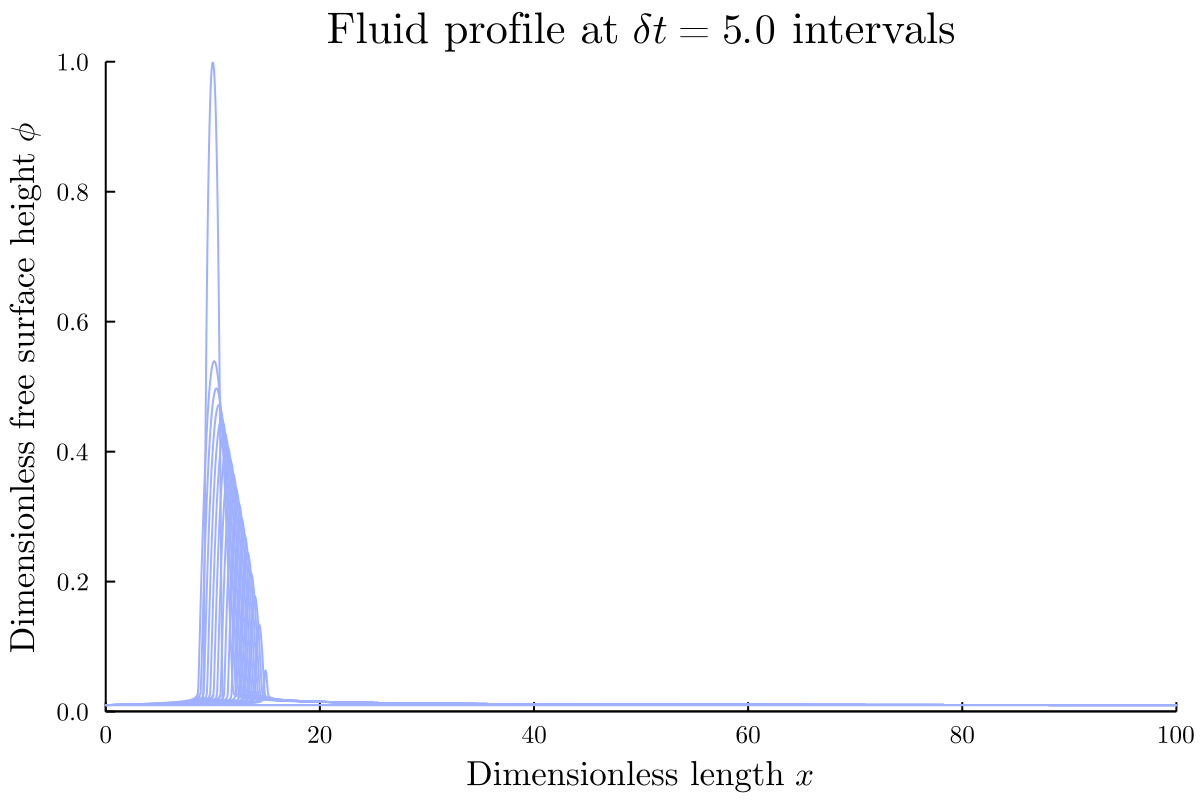

In [252]:
plt

┌ Info: Saved animation to 
│   fn = /var/folders/58/stll_lvs4sg8v_ry545yc1q80000gn/T/jl_9bQ9f8.gif
└ @ Plots /Users/bsamineni/.julia/packages/Plots/cPJQu/src/animation.jl:114


Plots.AnimatedGif("/var/folders/58/stll_lvs4sg8v_ry545yc1q80000gn/T/jl_9bQ9f8.gif")
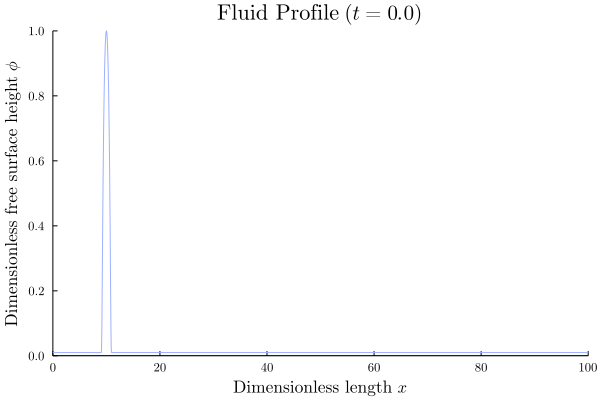

In [253]:
gif(anim, fps=30)

In [254]:
using Dates

date = string(Dates.format(now(), "YYYYmmdd"))
time = string(Dates.format(now(), "HHMMSS"))
path = "../runs/$date/$time"

mkpath(path)

gif(anim, path * "/flow.gif", fps = 30)
savefig(plt, path * "/plt.png")
fluid_data(sol, path)
save_params(path)

┌ Info: Saved animation to 
│   fn = /Users/bsamineni/Documents/research_projects/acoustics_thin_film/project/runs/20220415/114109/flow.gif
└ @ Plots /Users/bsamineni/.julia/packages/Plots/cPJQu/src/animation.jl:114


403

In [114]:
struct SolutionObj
    t::Vector{Float64}
    u::Vector{Vector{Float64}}
end

df = DataFrame(CSV.File("../runs/20220414/010820/data.csv"))
m = Matrix(df)
t = m[:, 1]
u = [m[i, 2:end] for i in 1:size(m, 1)]
sol = SolutionObj(t, u)
print("End")

End